In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import doubleml as dml
from tqdm.notebook import tqdm

In [2]:
def m(X):
    assert X.shape[1]==3
    return -X.sum(axis=1)

In [3]:
def g(X):
    assert X.shape[1]==3
    return X[:, 0] + np.exp(X[:, 1]) + np.int8(X[:, 2]>0) + 0.5*np.multiply(X[:, 0], X[:, 1])

In [4]:
def generate_data(n, dim, theta, random_state):
    np.random.seed(random_state)
    cov = make_spd_matrix(dim)
    X = np.random.multivariate_normal(np.zeros(dim), cov, n)
    D = m(X) + np.random.normal(0.0, 1.0, n)
    D = np.int8(D>0)
    y = theta*D + g(X) + np.random.normal(0.0, 1.0, n)
    df = pd.DataFrame(data=X)
    df['y'] = y
    df['D'] = D
    return df

In [5]:
def fit_DML(data, g_estimator_o, m_estimator_o, par_grids=None):
    if par_grids is None:
        x_col_names = list(data.columns)
        x_col_names.remove('y')
        x_col_names.remove('D')
        dml_data = dml.DoubleMLData(data=data, y_col='y', d_cols='D', x_cols=x_col_names)
        g_estimator = clone(g_estimator_o)
        m_estimator = clone(m_estimator_o)
        dml_est = dml.DoubleMLPLR(dml_data, g_estimator, m_estimator, n_folds=5)
        return dml_est.fit().summary

In [6]:
def fit_naive_reg(data):
    X = sm.add_constant(data.drop('y', axis=1))
    y = data['y']
    results = sm.OLS(y, X).fit()
    return pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0].loc['D']

In [7]:
def generate_estimates(repetitions, data_params, g_estimator, m_estimator):
    DML_results = pd.DataFrame()
    NR_results = pd.DataFrame()
    for i in tqdm(range(repetitions)):
        data = generate_data(**data_params, random_state=i)
        DML_results = DML_results.append(fit_DML(data, g_estimator, m_estimator))
        NR_results = NR_results.append(fit_naive_reg(data))
    return {'DML': DML_results, 'OLS': NR_results}

In [8]:
data_params = {'n': 5000,
               'dim': 3,
               'theta': 0.5}

In [9]:
generate_data(**data_params, random_state=0).to_csv("C:\\_Dissertation\\Data\\Story data n=5000.csv")

In [10]:
m_estimator = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
g_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [11]:
results = generate_estimates(100, data_params, g_estimator, m_estimator)

In [12]:
plt.rcParams["figure.figsize"] = (12,6)

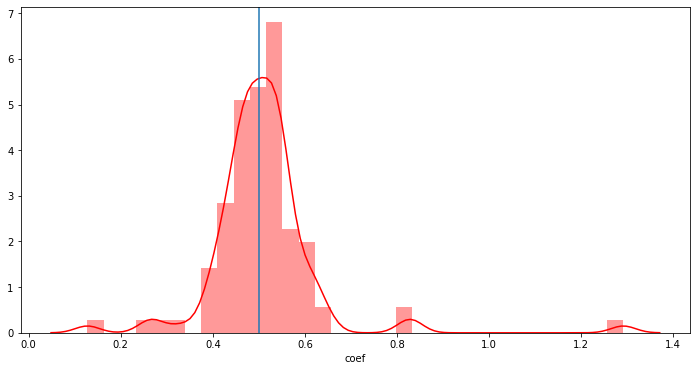

In [13]:
sns.distplot(results['DML']["coef"], color="red", label="DML", hist=True, kde=True)
plt.axvline(x=data_params['theta'], ymin=0, ymax=5)
plt.savefig('C:\\_Dissertation\\Histograms\\Story data n=5000 DML.png')

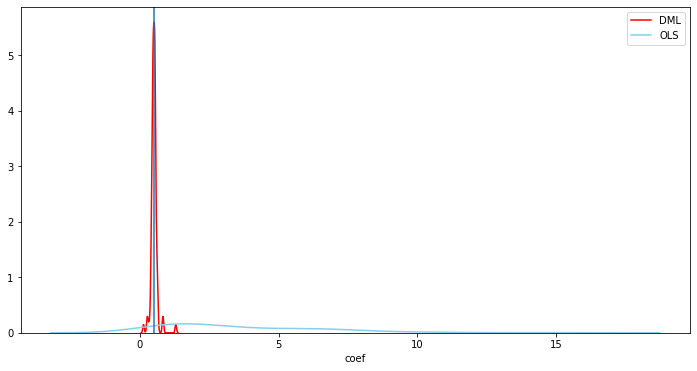

In [14]:
sns.distplot(results['DML']["coef"], color="red", label="DML", hist=False, kde=True)
sns.distplot(results['OLS']["coef"], color="skyblue", label="OLS", hist=False, kde=True)
plt.axvline(x=data_params['theta'], ymin=0, ymax=5)
plt.savefig('C:\\_Dissertation\\Histograms\\Story data n=5000 DML, OLS.png')

In [15]:
results['DML'].index = range(len(results['DML']))
results['DML'].to_csv("C:\\_Dissertation\\Histograms\\Story data n=5000 DML.csv")

In [16]:
results['OLS'].index = range(len(results['OLS']))
results['OLS'].to_csv("C:\\_Dissertation\\Histograms\\Story data n=5000 OLS.csv")